In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer
import re
import nltk
from sklearn.preprocessing import normalize
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
import pandas as pd
import os
import pickle
from nltk.tokenize import word_tokenize
import json
from sklearn.feature_extraction import text

In [ ]:
stemmer = PorterStemmer()
nltk.data.path.append('/root/nltk_data')
nltk.download('punkt')
nltk.download('stopwords')


def preprocess_lyrics(lyrics):
    # Check if the lyrics are valid (not null and are strings)
    if isinstance(lyrics, str):
        # Remove special characters, numbers, etc.
        lyrics = re.sub(r'[^a-zA-Z\s]', '', lyrics)
        # Convert to lowercase
        lyrics = lyrics.lower()

        # Tokenize the text
        tokens = word_tokenize(lyrics)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

        # Apply stemming
        tokens = [stemmer.stem(word) for word in tokens]

        # Join back the processed tokens into a string
        lyrics = ' '.join(tokens)
    else:
        # If not a valid string, return an empty string
        lyrics = ''

    return lyrics


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
folder_path = '/content/drive/My Drive/csv-3'

all_cleaned_lyrics = []
song_indices = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)

        # Extract genre from filename (assuming filenames represent genres)
        genre = os.path.splitext(filename)[0]

        try:
            df = pd.read_csv(file_path)
            print(f"Successfully loaded {filename} with {len(df)} rows.")  # Debug: Print number of rows loaded
            print(df.head())
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            continue  # Skip this file if there's an issue

        # Preprocess the lyrics
        df['cleaned_lyrics'] = df['Lyric'].apply(preprocess_lyrics)

        # Filter out rows where lyrics are empty after preprocessing
        df = df[df['cleaned_lyrics'].str.strip() != '']
        all_cleaned_lyrics.extend(df['cleaned_lyrics'].tolist())

        # Add song titles (or any other identifier like row indices) with genre to song_indices
        song_indices.extend([(row['Song'], genre) for _, row in df.iterrows()])

# Save song indices as JSON file
json_file_path_indices = 'song_indices_with_genre.json'
with open(json_file_path_indices, 'w') as json_file:
    json.dump(song_indices, json_file, ensure_ascii=False, indent=4)

# Save all_cleaned_lyrics as JSON file
json_file_path_lyrics = 'all_cleaned_lyrics.json'
with open(json_file_path_lyrics, 'w') as json_file:
    json.dump(all_cleaned_lyrics, json_file, ensure_ascii=False, indent=4)



In [ ]:
def em_algorithm(X, P_d_z, P_w_z, P_z, num_iter=1000, tol=1e-5):
    n_docs, n_words = X.shape
    n_topics = P_d_z.shape[1]

    prev_likelihood = -np.inf  # Previous likelihood for convergence check

    for iteration in range(num_iter):
        print(f"Iteration {iteration + 1}")

        # E-step: Calculate P(z|d,w)
        P_z_dw = np.einsum('ik,jk,k->ijk', P_d_z, P_w_z, P_z)
        denominator = np.einsum('ik,jk,k->ij', P_d_z, P_w_z, P_z)
        P_z_dw /= denominator[:, :, np.newaxis] + 1e-10

        # M-step: Update P(d|z), P(w|z), and P(z)
        P_d_z = np.einsum('ij,ijk->ik', X, P_z_dw)
        P_d_z /= P_d_z.sum(axis=0, keepdims=True)

        P_w_z = np.einsum('ij,ijk->jk', X, P_z_dw)
        P_w_z /= P_w_z.sum(axis=0, keepdims=True)

        P_z = np.einsum('ij,ijk->k', X, P_z_dw)
        P_z /= P_z.sum()

        # Likelihood calculation
        estimated_X = np.dot(P_d_z, P_w_z.T)
        likelihood = np.sum(X * np.log1p(estimated_X))

        print(f"Likelihood: {likelihood}")

        # Check for convergence
        if iteration > 0 and np.abs(likelihood - prev_likelihood) < tol:
            print(f"Convergence achieved at iteration {iteration + 1}")
            break
        prev_likelihood = likelihood

    return P_d_z, P_w_z, P_z


In [ ]:
extra_stopwords = ['hmmmmm','ah','someth','caus','kany','ill','wan','ive','want','id','ayo','arent','laci','steve','na','daniel','caesar','mayb','em','oh','song', 'lyrics', 'chorus', 'kendrick', 'lamar', 'choru', 'ye', 'ooh', 'dont', 'kanye','vincent','aah', 'vers','like','intro','hello', 'aaliyah','skit', 'hmmmmm ', 'aint', 'im','yeah','yo','brent','faiyaz','mm']

custom_stop_words = list(text.ENGLISH_STOP_WORDS.union(extra_stopwords))

max_df = 0.95
min_df = 2

# Step 1: Convert the cleaned lyrics to a Bag-of-Words model with custom stopwords
vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words=custom_stop_words)
X_bag_of_words = vectorizer.fit_transform(all_cleaned_lyrics)

# Step 2: Convert the cleaned lyrics to a Term Frequency-Inverse Document Frequency (TF-IDF) model with custom stopwords
tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words=custom_stop_words)
X_tfidf = tfidf_vectorizer.fit_transform(all_cleaned_lyrics)

print(f"Bag-of-Words Matrix Shape: {X_bag_of_words.shape}")
print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")

# Get feature names (words)
bag_of_words_features = vectorizer.get_feature_names_out()
tfidf_features = tfidf_vectorizer.get_feature_names_out()

print(f"Sample Bag-of-Words Features: {bag_of_words_features[:10]}")
print(f"Sample TF-IDF Features: {tfidf_features[:10]}")

# pd.DataFrame(X_tfidf.toarray(), columns=tfidf_features).to_csv('tfidf.csv', index=False)


Bag-of-Words Matrix Shape: (322, 3017)
TF-IDF Matrix Shape: (322, 3017)
Sample Bag-of-Words Features: ['abandon' 'abl' 'abort' 'absolut' 'abus' 'abusin' 'accent' 'accept'
 'accid' 'accident']
Sample TF-IDF Features: ['abandon' 'abl' 'abort' 'absolut' 'abus' 'abusin' 'accent' 'accept'
 'accid' 'accident']


In [ ]:
X_array = X_tfidf.toarray()

# Step 2: pLSA parameters
n_docs, n_words = X_array.shape
n_topics = 10

# Initialize P(d|z), P(w|z), and P(z)
P_d_z = np.random.dirichlet(np.ones(n_topics), n_docs)
P_w_z = np.random.dirichlet(np.ones(n_topics), n_words)
P_z = np.random.dirichlet(np.ones(n_topics))

In [ ]:
# Step 4: Run the algorithm with the corrected version
P_d_z, P_w_z, P_z = em_algorithm(X_array, P_d_z, P_w_z, P_z)

# Step 5: Display the top words for each topic
def display_topics(P_w_z, feature_names, no_top_words):
    for topic_idx, topic in enumerate(P_w_z.T):
        top_word_indices = topic.argsort()[:-no_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        print(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Display top words for each topic
display_topics(P_w_z, feature_names, 10)


Iteration 1
Likelihood: 0.09012480745612422
Iteration 2
Likelihood: 0.09464027884012552
Iteration 3
Likelihood: 0.10055873408909156
Iteration 4
Likelihood: 0.10769444203676992
Iteration 5
Likelihood: 0.11492302647439569
Iteration 6
Likelihood: 0.12124683697411197
Iteration 7
Likelihood: 0.12639855407176404
Iteration 8
Likelihood: 0.1304292922986923
Iteration 9
Likelihood: 0.1335003324505679
Iteration 10
Likelihood: 0.13583670011505147
Iteration 11
Likelihood: 0.13764630328045496
Iteration 12
Likelihood: 0.13906970781014721
Iteration 13
Likelihood: 0.1402106060768087
Iteration 14
Likelihood: 0.14114785959112514
Iteration 15
Likelihood: 0.14193266613663288
Iteration 16
Likelihood: 0.1425988406653435
Iteration 17
Likelihood: 0.14317091473599802
Iteration 18
Likelihood: 0.14366299023755552
Iteration 19
Likelihood: 0.1440762828750055
Iteration 20
Likelihood: 0.14441587516335505
Iteration 21
Likelihood: 0.1446966047857719
Iteration 22
Likelihood: 0.1449374012293288
Iteration 23
Likelihood: 0

In [ ]:
import pickle

def save_model(P_d_z, P_w_z, P_z, filename='plsa_model.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump((P_d_z, P_w_z, P_z), f)
    print(f"Model saved to {filename}")

save_model(P_d_z, P_w_z, P_z)


Model saved to plsa_model.pkl


In [ ]:

def load_model(filename='plsa_model.pkl'):
    with open(filename, 'rb') as f:
        P_d_z, P_w_z, P_z = pickle.load(f)
    print(f"Model loaded from {filename}")
    return P_d_z, P_w_z, P_z

P_d_z, P_w_z, P_z = load_model()


Model loaded from plsa_model.pkl


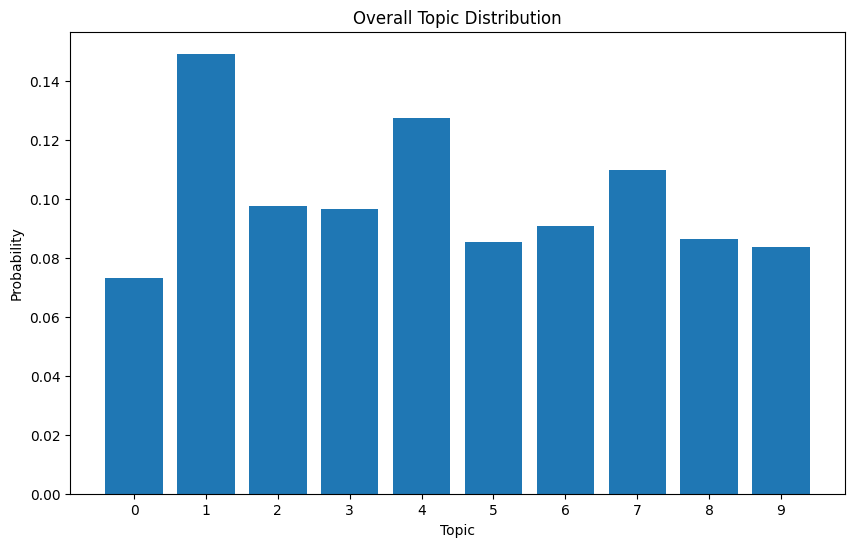

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

def plot_topic_distribution(P_z):
    plt.figure(figsize=(10, 6))
    topics = range(len(P_z))  # Number of topics
    plt.bar(topics, P_z)
    plt.title("Overall Topic Distribution")
    plt.xlabel("Topic")
    plt.ylabel("Probability")
    plt.xticks(topics)
    plt.show()

plot_topic_distribution(P_z)


In [ ]:
import matplotlib.pyplot as plt

iterations = list(range(1, 163))  # Iterations from 1 to 162
likelihoods = [
    0.09012480745612422, 0.09464027884012552, 0.10055873408909156, 0.10769444203676992,
    0.11492302647439569, 0.12124683697411197, 0.12639855407176404, 0.1304292922986923,
    0.1335003324505679, 0.13583670011505147, 0.13764630328045496, 0.13906970781014721,
    0.1402106060768087, 0.14114785959112514, 0.14193266613663288, 0.1425988406653435,
    0.14317091473599802, 0.14366299023755552, 0.1440762828750055, 0.14441587516335505,
    0.1446966047857719, 0.1449374012293288, 0.14515443637577735, 0.14535868644537828,
    0.14555227212505484, 0.14574073589307532, 0.14593078085197433, 0.14611872268686188,
    0.1462991159535671, 0.14646893856136536, 0.14662780216782667, 0.1467775811411705,
    0.14692042793348048, 0.1470607846676534, 0.147199920576607, 0.14733764165498384,
    0.14747154177360167, 0.1475972808613165, 0.14771195256148392, 0.14781517811235215,
    0.1479142663029855, 0.14800522987403847, 0.14809060584506734, 0.14817324648538688,
    0.1482522875080243, 0.14832639039435466, 0.14839660440626906, 0.1484635884091592,
    0.14852744600295334, 0.1485902417037083, 0.1486536016294872, 0.14871822440863564,
    0.1487838618674402, 0.14884757203451926, 0.14890959183278035, 0.14897341320177598,
    0.14903908338042346, 0.14910515267142627, 0.14917269130515054, 0.14924562441444242,
    0.14932328555245641, 0.1494001275321288, 0.14947536663130237, 0.14954965542933496,
    0.14962233970778477, 0.14969294913270975, 0.14976354523305085, 0.14983680937458996,
    0.1499119567191907, 0.1499869089170847, 0.1500588838397475, 0.1501280315213371,
    0.15019519229394837, 0.1502629043869721, 0.150328471855025, 0.1503917740576608,
    0.1504555593410117, 0.1505185866792543, 0.15058078418973447, 0.15064445057621106,
    0.15070738473497008, 0.1507667721315008, 0.1508253368133756, 0.15088763596141802,
    0.15095236568373013, 0.15101022463335642, 0.1510585740262982, 0.15110180371733842,
    0.15114542418704502, 0.15119203433201037, 0.15124222300922963, 0.151297561191304,
    0.15135575155336212, 0.15141175969695278, 0.15146372297166522, 0.151508179543676,
    0.1515474385608385, 0.15158395882057352, 0.15162372799871232, 0.1516708647198865,
    0.15172536530709985, 0.15178176535776292, 0.151830574280889, 0.1518712820693884,
    0.15190943922748243, 0.15194373420329108, 0.151972129130929, 0.15199651199518108,
    0.1520205375784344, 0.15204660527007818, 0.1520740914551381, 0.15210029850019788,
    0.15212343565211217, 0.15214332375067235, 0.15216131002233096, 0.15217843363408706,
    0.15219597682113586, 0.15221703879945933, 0.1522471166224961, 0.1522817174164025,
    0.1523098960012635, 0.1523313211604362, 0.15234857030561957, 0.15236521159754673,
    0.15238594448630333, 0.1524117015168563, 0.15243794307031153, 0.1524610317177286,
    0.15247964137582487, 0.15249581909093965, 0.15251252880653135, 0.15253170167243313,
    0.15255029616489366, 0.1525672326163457, 0.15258662803773596, 0.15261032127057164,
    0.1526394261988043, 0.15266902052371364, 0.15269470187154852, 0.15271756751113966,
    0.15273989863549015, 0.1527627259252394, 0.1527869993087101, 0.15281504173993501,
    0.1528470173490729, 0.15287581993678237, 0.15289959601182018, 0.1529202893902337,
    0.15294002447071245, 0.15296051614613346, 0.15297806958256577, 0.1529932289667791,
    0.15300715425424638, 0.15301925243624737, 0.1530304993719407, 0.1530420041429804,
    0.1530540859561739, 0.15306636347880165, 0.1530782312397251, 0.15308934120511264,
    0.15309974495613402, 0.15310941638022746
]

# Plotting the likelihoods over iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, likelihoods, color='b', label="Log Likelihood")
plt.xlabel("Iterations")
plt.ylabel("Log Likelihood")
plt.title("Convergence of Log Likelihood over Iterations")
plt.axvline(x=162, color='r', linestyle='--', label="Convergence Iteration")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# New input
new_lyrics = """
Poverty's paradise I don't think I could find a way to make it on this earth
What's up family, yeah, this yo' cousin Carl, man, just givin' you a call, man
I know you been havin' a lot on yo' mind lately
And I know you feel like, you know, people ain't been prayin' for you
But you have to understand this, man, that we are a cursed people
Deuteronomy 28:28 says "The Lord shall smite thee with madness, and blindness and astonishment of heart"
See, family, that's why you feel like you feel like you got a chip on your shoulder
Until you follow His commandments, you gonna feel that way
Why God, why God do I gotta suffer? Pain in my heart carry burdens full of struggle
Why God, why God do I gotta bleed? Every stone thrown at you restin' at my feet
Why God, why God do I gotta suffer? Earth is no more, why don't you burn this muhf-?
(I don't think I could find a way to make it on this earth)
I beat yo' ass, keep talkin' back I beat yo' ass, who bought you that?
You stole it, I beat yo' ass if you say that game is broken
I beat yo' ass if you jump on my couch I beat yo' ass if you walk in this house with tears in your eyes
Runnin' from Poo Poo and Prentice Go back outside, I beat yo' ass, lil' -
That homework better be finished, I beat yo' ass Yo' teachers better not be b- 'bout you in class
That pizza better not be wasted, you eat it all
That TV better not be loud if you got it on
Them Jordans better not get dirty when I just bought 'em
Better not hear 'bout you - on Keisha's daughter
Better not hear you got caught up, I beat yo' ass
You better not run to your father, I beat yo' ass
You know my patience runnin' thin I got beaucoup payments to make
County building's on my ass, tryna take my food stamps away
I beat yo' ass if you tell them social workers he live here
I beat yo' ass if I beat yo' ass twice and you still here
Seven years old, think you run this house by yourself?
N-, you gon' fear me if you don't fear no one else
If I could smoke fear away, I roll that motherf- up
And then I'd take two puffs Now (huh), now (huh)
Now (huh), now (huh) Life's a b-, pull them - to the side now
(pull them - to the side now) (I don't think I could find a way to make it on this earth)
I'll prolly die anonymous, I'll prolly die with promises
I'll prolly die walkin' back home from the candy house
I'll prolly die because these colors are standin' out
I'll prolly die because I ain't know Demarcus was snitchin'
I'll prolly die at these house parties - I'll prolly die from witnesses leavin' me false accused
I'll prolly die from thinkin' that me and your hood was cool
Or maybe die from pressin' the line, actin' too extra
Or maybe die because these smokers are more than desperate
I'll prolly die from one of these bats and blue badges
Body slammed on black and white paint, my bones snappin'
Or maybe die from panic or die from bein' too lax
Or die from waitin' on it, die 'cause I'm movin' too fast
I'll prolly die tryna buy - at the apartments
I'll prolly die tryna diffuse two homies arguin'
I'll prolly die 'cause that's what you do when you're 17
All worries in a hurry, I wish I controlled things
If I could smoke fear away, I'd roll that mothaf- up
And then I'd take two puffs I've been hungry all my life
Now (huh), now (huh) Now (huh), now (huh)
Life's a b-, pull them - to the side now (pull them - to the side now), now
When I was 27, I grew accustomed to more fear
Accumulated 10 times over throughout the years
My newfound life made all of me magnified
How many accolades do I need to block denial?
The shock value of my success put bolts in me
All this money, is God playin' a joke on me?
Is it for the moment and will he see me as Job?
Take it from me and leave me worse than I was before?
At 27, my biggest fear was losin' it all
Scared to spend money, had me sleepin' from hall to hall
Scared to go back to Section 8 with my mama stressin'
30 shows a month and I still won't buy me no Lexus
What is an advisor somebody that's holdin' my checks?
Just to f- me over and put my finances in debt?
I read a case about Rihanna's accountant and wondered
How did the bad girl feel when she looked at them numbers?
The type of - make me flip out and just - somethin', drill somethin'
Get ill and fill ratchets with a lil' somethin'
I practiced runnin' from fear, guess I had some good luck
At 27 years old, my biggest fear was bein' judged
How they look at me reflect on myself, my family, my city
What they say 'bout me reveal if my reputation would miss me
What they see from me would trickle down generations in time
What they hear from me would make 'em highlight my simplest lines
I'm talkin' fear, fear of losin' creativity
I'm talkin' fear, fear of missin' out on you and me
I'm talkin' fear, fear of losin' loyalty from pride
'Cause my DNA won't let me involve in the light of God
I'm talkin' fear, fear that my humbleness is gone
I'm talkin' fear, fear that love ain't livin' here no more
I'm talkin' fear, fear that it's wickedness or weakness
Fear, whatever it is, both is distinctive
Fear, what happens on Earth stays on Earth
And I can't take these feelings with me, so hopefully they disperse
Within 14 tracks, carried out over wax
Searchin' for resolutions until somebody get back
Fear, what happens on Earth stays on Earth
And I can't take these feelings with me, so hopefully they disperse
Within 14 tracks, carried out over wax
Wonderin' if I'm livin' through fear or livin' through rap
Damn Goddamn you Goddamn me
Goddamn us Goddamn we
Goddamn us all
Therefore I will punish you for all your iniquities
So until we come back to these commandments
Until you come back to these commandments
We're gonna be in this place, we're gonna be under this curse
Because He said He's gonna punish us
The so-called Blacks, Hispanics, and Native American Indians
Are the true children of Israel
We are the Israelites according to the Bible
The children of Israel, he's gonna punish us for our iniquities
For our disobedience because we chose to follow other gods
That man chastens his son, so the Lord, thy God, chasten thee
So just like you'll chasten your own son
He's gonna chasten you because He loves you
So that's why we get chastised, that's why we're in the position we're in
Until we come back to these laws, statutes and commandments
And do what the Lord said, these curses is gonna be upon us
We gonna be at a lower state in this life that we live, here, in today
In the United States of America
I love you, family, and I pray for you
God bless you, shalom
"""

# Step 1: Preprocess the new lyrics
preprocessed_lyrics = preprocess_lyrics(new_lyrics)

# Step 2: Vectorize the corpus first
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=custom_stop_words)
X_corpus = vectorizer.fit_transform(all_cleaned_lyrics)  # Fit the vectorizer on the existing corpus (all_cleaned_lyrics)

# Step 3: Vectorize the new lyrics using the fitted vectorizer
new_X = vectorizer.transform([preprocessed_lyrics]).toarray()

# Step 4: Calculate the topic distribution for the new lyrics
P_z_new = np.dot(new_X, P_w_z)  # P(z|d) = X * P(w|z)
P_z_new /= P_z_new.sum()  # Normalize

# Step 5: Return the top topic for the new song
top_index = np.argmax(P_z_new[0])  # Get the index of the highest probability
print(f"Top Topic for the New Song: Topic {top_index + 1} with Probability {P_z_new[0][top_index]:.4f}")

Top Topic for the New Song: Topic 3 with Probability 0.1243


In [ ]:
# Step 6: Calculate the topic distribution for all songs in the corpus
P_z_corpus = np.dot(X_corpus.toarray(), P_w_z)  # P(z|d) = X * P(w|z)
row_sums = P_z_corpus.sum(axis=1, keepdims=True)

# Avoid division by zero by adding a very small number (epsilon) where row sums are zero
epsilon = 1e-10
row_sums[row_sums == 0] = epsilon

# Step 6.2: Normalize for each song
P_z_corpus /= row_sums

# Step 7: Find the songs with the highest probability for the top topic
related_song_indices = np.argsort(P_z_corpus[:, top_index])[::-1]  # Sort by highest probability for the top topic

# Step 8: Output the related songs
print("\nTop Related Songs for the New Song's Top Topic:")
top_n = 5  # Number of top related songs to display
for idx in related_song_indices[:top_n]:
    # Retrieve song name from song_indices
    song_name = song_indices[idx]
    print(f"Song: {song_name} | Probability {P_z_corpus[idx, top_index]:.4f}")



Top Related Songs for the New Song's Top Topic:
Song: ('A Love Supreme, Part 1: Acknowledgment', 'Jazz') | Probability 0.4150
Song: ('The End', 'Rock') | Probability 0.3516
Song: ('LoveGame', 'Pop') | Probability 0.2846
Song: ('Let Me Put My Love into You', 'Rock') | Probability 0.2676
Song: ('Because', 'Rock') | Probability 0.2601
